In [290]:
from inference_script import DetectionAnalysis
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [291]:
results_file = Path("../results/benedict/v2z6t9wz.csv")
df = pd.read_csv(results_file)
df.head()

,y_pred,y_score,y_true,snr,correct
0,0,-2.705725e-03,0,0.000000,True
1,1,-1.192093e-07,1,29.373680,True
2,1,-1.192093e-07,1,28.873734,True
3,1,-3.337855e-06,1,23.783968,True
4,0,-1.546855e-03,0,0.000000,True


In [292]:
# print absolute accuracy
print(f"Accuracy over test set: {df['correct'].mean():.2%}")

Accuracy over test set: 98.05%


In [293]:
# get samples where snr is between 0 and 10 (These seem to be errors in the dataset)
# TODO: Investigate why these samples exist?
df_snr_0_10 = df[(df["snr"] > 0) & (df["snr"] <= 10)]
df_snr_0_10

# remove these samples
df = df[~((df["snr"] > 0) & (df["snr"] <= 10))]
print(f"Number of samples after removing: {len(df)}, removed {len(df_snr_0_10)} samples")

Number of samples after removing: 19997, removed 23 samples


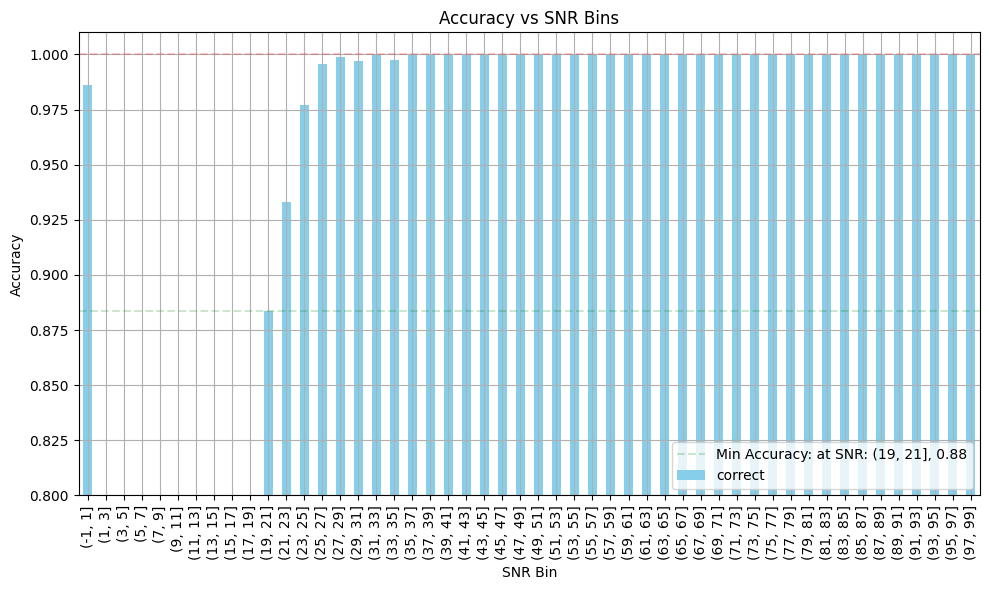

In [294]:
# accuracy vs SNR bins
# bins = np.arange(0, df["snr"].max()+1, 1)
bins = np.arange(-1, 100, 2)
acc_by_bin = df.assign(snr_bin=pd.cut(df["snr"], bins=bins)).groupby("snr_bin", observed=False)["correct"].mean()

# plot accuracy vs SNR bins (show only > 0.5)
plt.figure(figsize=(10, 6))
acc_by_bin.plot(kind='bar', color='skyblue')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.2)

# line at min accuracy
plt.axhline(y=acc_by_bin.min(), color='green', linestyle='--', alpha=0.2, label=f'Min Accuracy: at SNR: {acc_by_bin.idxmin()}, {acc_by_bin.min():.2f}')

plt.title('Accuracy vs SNR Bins')
plt.xlabel('SNR Bin')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

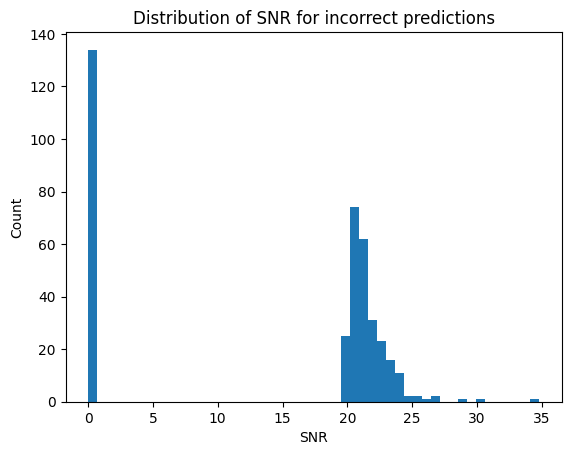

In [295]:
# plot distribution of snr for incorrect
plt.hist(df[~df["correct"]]["snr"], bins=50)
plt.xlabel("SNR")
plt.ylabel("Count")
plt.title("Distribution of SNR for incorrect predictions")
plt.show()

In [296]:
analysis = DetectionAnalysis(df["snr"], df["y_true"], df["y_score"])

In [297]:
fpr, tpr, roc_auc = analysis.compute_roc()
print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"ROC AUC: {roc_auc}")


FPR: [0.        0.        0.        ... 0.9999005 1.        1.       ]
TPR: [0.         0.52508294 0.56238062 ... 0.9993968  0.9993968  1.        ]
ROC AUC: 0.8901173983305549


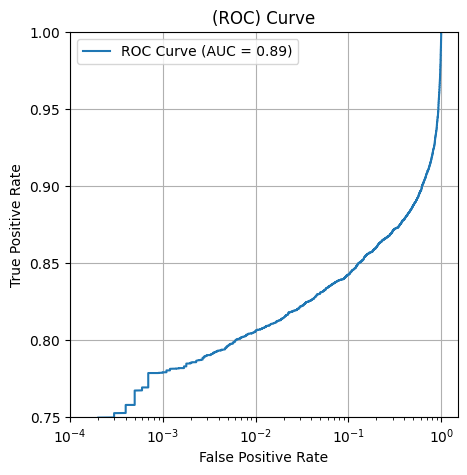

In [298]:
# plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')


plt.ylim(0.75, 1.)
plt.xlim(10e-5, 1.5)
plt.xscale('log')
plt.legend()
plt.grid()

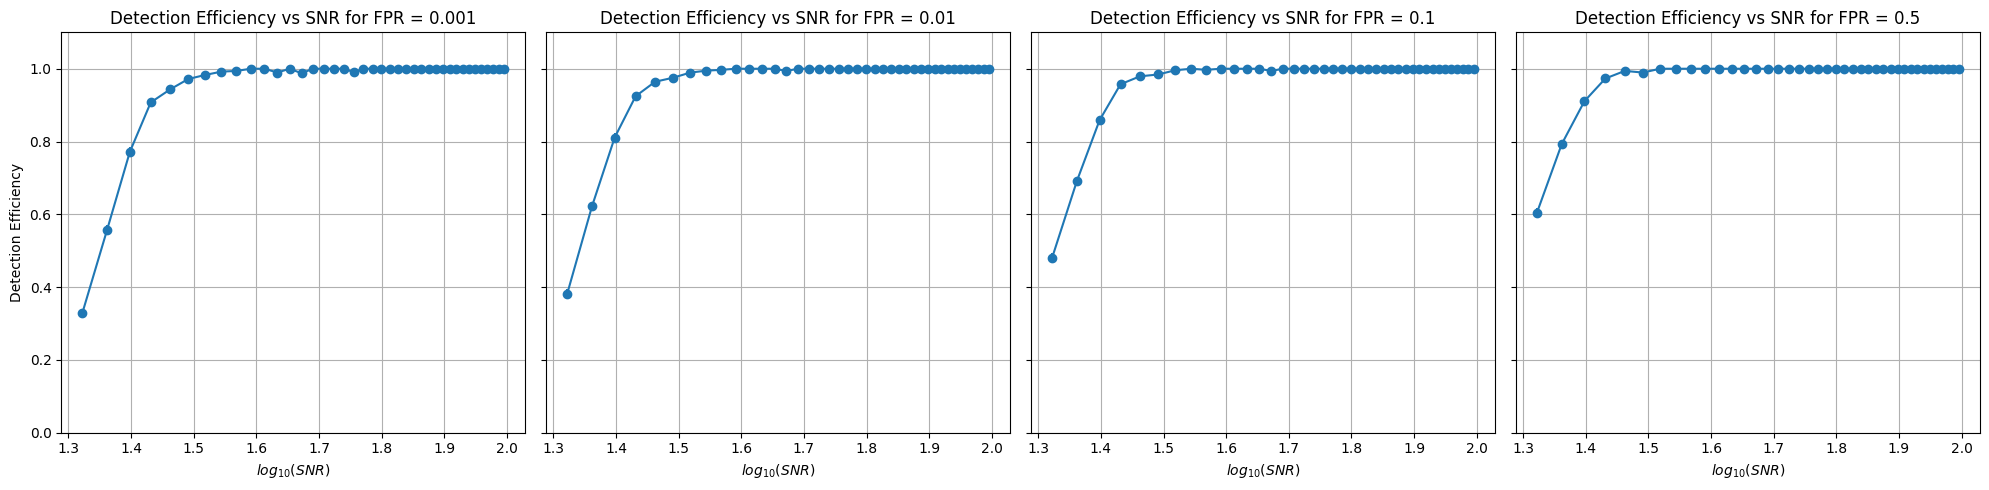

In [299]:
fprs = [0.001, 0.01, 0.1, 0.5]

fig, axes = plt.subplots(ncols=len(fprs), figsize=(5*len(fprs), 5), sharey=True)

for i, (fpr, ax) in enumerate(zip(fprs, axes)):
    bin_centers, efficiency, errors = analysis.compute_efficiency(fpr)
    ax.errorbar(np.log10(bin_centers), efficiency, yerr=errors, fmt='-o', label='Efficiency')
    ax.set_xlabel(r'$log_{10}(SNR)$')
    ax.grid()
    ax.set_title(f'Detection Efficiency vs SNR for FPR = {fpr}')

# shared y-axis
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel('Detection Efficiency')

plt.tight_layout()
plt.show()
